In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from joblib import dump
import json

# Загрузка данных и первичный анализ

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/mirea-aie-2025/aie-course-meta/main/seminars/S06/S06-hw-dataset-04.csv')
data.head()

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,target
0,1,-1.250210,1.423474,-0.225004,-4.023138,-0.832729,-0.550874,1.772090,2.761690,-0.698750,-1.857165,-2.988932,-0.222654,7.902889,-0.457478,1.252598,-1.904442,1.880979,-1.270543,2.499577,-1.061677,0.289405,-1.345681,0.802753,-2.831077,-2.436557,-1.033311,-1.389771,0.982706,-1.477958,-1.271224,1.057974,-0.538491,-1.439327,-0.379149,-1.426534,3.930176,-0.095083,-2.532206,1.132533,0.000992,0.115966,-1.325814,2.016271,1.571126,-0.129857,0.198888,2.573738,0.146024,-0.838329,-2.700143,1.130519,10.938269,0.501178,1.600001,0.314212,1.209735,1.355697,-5.338924,1.153944,-0.153934,0
1,2,0.074328,0.376429,0.212831,-0.502074,2.017405,0.625496,1.943785,1.242030,-0.524090,-0.009307,-2.368230,-1.065692,4.262293,-0.839336,-1.209031,1.184690,-0.456587,0.709568,0.007754,-0.489247,-0.732846,-0.302897,0.885109,-0.420760,-0.131808,0.480478,3.283268,-0.516650,1.101251,0.855135,0.931559,0.321548,-0.757301,-0.264393,-0.444227,-3.961874,0.315207,-1.964478,0.064992,0.197988,-2.344300,1.408680,-1.176433,1.343031,0.424162,1.616086,-1.334528,0.733665,0.724584,-1.699918,-0.311057,7.775262,-4.550195,6.272586,-0.932162,-0.228543,1.735220,-3.827828,0.292165,0.273720,0
2,3,0.638481,0.060968,0.746760,2.479653,-0.292858,-0.078139,-2.918423,-0.013186,1.009135,-4.966481,6.751014,0.782321,-6.117275,1.040027,-1.059119,-2.712538,0.248385,0.643785,0.053492,-0.243807,0.150096,-0.081965,0.382776,-1.135947,1.093997,-0.239150,3.870957,0.082734,3.202779,-0.829286,1.025113,0.201753,-0.550331,-1.608367,-1.453033,-2.941346,1.886129,2.112847,-1.240350,0.592880,-2.211349,-0.147429,3.971088,-0.709087,0.134511,-1.109861,-5.068009,-2.037237,0.231072,1.418795,-1.159370,-4.448447,-9.593179,-3.093519,0.029321,0.605511,0.829103,-0.085985,2.891408,0.766221,0
3,4,1.712916,-1.350969,-0.256473,1.622074,-0.445141,0.911932,-3.440345,1.505192,-1.104348,0.291916,9.930413,1.760955,7.524514,-0.254240,-2.467102,0.755289,-1.488300,0.507489,-1.238711,-0.180049,0.320420,1.679410,-0.142667,0.964114,-1.937054,0.196951,0.952717,0.024926,-0.859463,-0.073649,0.434144,0.107971,2.630164,2.215266,-1.470316,-3.971211,1.264404,0.841051,-0.129529,-1.394101,-0.639196,-0.855570,-1.978907,1.004087,1.130131,-0.001248,-0.489862,-0.786501,1.001892,1.102938,0.662697,-1.619072,-3.237479,-5.474038,-1.582475,0.198137,3.823409,0.880395,1.148610,0.136732,0
4,5,0.905676,-0.206545,-0.068806,4.086026,-1.010045,-0.772644,-4.207688,2.506104,1.589143,-0.849466,12.188465,-0.171950,12.222763,-0.475136,-4.429834,2.851249,-0.346919,0.384681,-2.391352,0.161604,-0.375671,-1.002666,-1.292100,1.891201,-2.753454,2.222520,4.040751,1.906889,-1.565578,1.190694,-0.622997,1.408048,1.283413,0.076156,1.986580,-9.275539,-0.267379,3.232339,1.434700,1.502491,-0.275709,-1.340376,-2.766430,-0.109198,0.350301,0.043001,-3.124848,-0.202499,-0.479611,-1.057274,1.245923,-2.396844,-10.540129,-5.532811,-1.231203,0.000119,4.298572,-1.558235,0.924673,0.111668,0


In [ ]:
data.info() # Пропусков нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 62 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      25000 non-null  int64  
 1   f01     25000 non-null  float64
 2   f02     25000 non-null  float64
 3   f03     25000 non-null  float64
 4   f04     25000 non-null  float64
 5   f05     25000 non-null  float64
 6   f06     25000 non-null  float64
 7   f07     25000 non-null  float64
 8   f08     25000 non-null  float64
 9   f09     25000 non-null  float64
 10  f10     25000 non-null  float64
 11  f11     25000 non-null  float64
 12  f12     25000 non-null  float64
 13  f13     25000 non-null  float64
 14  f14     25000 non-null  float64
 15  f15     25000 non-null  float64
 16  f16     25000 non-null  float64
 17  f17     25000 non-null  float64
 18  f18     25000 non-null  float64
 19  f19     25000 non-null  float64
 20  f20     25000 non-null  float64
 21  f21     25000 non-null  float64
 22

In [ ]:
data.describe()

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,target
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000
mean,12500.500000,-0.000386,-0.004872,0.003202,0.335329,-0.000563,-0.010118,0.001182,0.957385,-0.004658,-0.051834,2.136948,-0.005161,1.516581,-0.002771,0.058231,0.959688,-0.005923,-0.016326,0.000620,0.003791,0.006971,-0.003368,-0.003807,0.005663,0.058492,-0.004588,1.651984,0.003594,0.001046,0.005267,0.003484,-0.005305,0.014476,0.004144,-0.000301,-2.091590,0.004863,0.966712,-0.001868,0.001915,-0.953057,-0.014028,0.266603,-0.005649,0.019782,-0.306055,-0.932300,-0.006917,-0.006525,-1.087836,-0.000535,-0.166251,-3.387506,1.749793,-0.013017,-0.001383,0.893365,-0.909479,0.000570,-0.000754,0.04920
std,7217.022701,1.001623,0.995606,1.004367,3.207537,0.993965,1.002172,2.432162,1.830223,1.013470,3.685062,5.375571,0.999336,5.296840,1.005267,2.307648,1.925062,0.999312,0.999002,0.995565,0.998510,0.993150,0.990000,1.002894,0.996802,2.254469,1.002745,4.725056,0.992412,2.234487,1.002033,1.002197,0.999154,1.766320,1.002670,1.003289,4.911731,1.002999,1.984146,1.001389,1.002064,1.897981,1.003231,4.667307,0.997118,1.005644,3.122688,2.116074,1.011754,1.000219,3.020606,1.001149,4.234741,4.331576,5.318660,1.001594,0.996409,2.445185,1.962618,0.994320,0.997167,0.21629
min,1.000000,-4.370993,-4.087073,-4.103875,-13.249937,-4.118778,-3.895974,-8.883224,-8.132548,-4.068933,-18.631100,-19.185255,-3.879800,-27.370015,-3.688094,-10.583428,-7.462415,-4.334166,-4.184241,-3.924360,-3.996723,-3.782408,-3.928021,-3.971838,-4.324822,-7.969531,-3.598341,-18.562670,-3.783731,-8.577577,-4.134743,-4.187763,-4.300137,-9.089844,-3.925411,-3.711762,-20.215101,-4.259412,-7.456727,-4.198315,-4.149879,-8.332765,-4.806904,-20.712312,-3.984365,-3.896346,-13.179816,-9.167405,-4.534320,-4.192619,-13.537216,-4.065387,-20.021141,-18.332290,-20.336666,-4.349216,-4.119472,-9.508509,-7.919287,-4.038312,-3.812255,0.00000
25%,6250.750000,-0.680165,-0.675100,-0.675426,-1.750048,-0.669764,-0.674374,-1.647977,-0.217260,-0.688278,-2.440931,-1.514280,-0.685630,-1.986628,-0.672446,-1.441004,-0.346044,-0.684527,-0.684371,-0.668376,-0.671727,-0.673078,-0.673003,-0.680049,-0.664063,-1.500069,-0.679541,-1.381206,-0.666035,-1.549236,-0.675942,-0.667608,-0.680463,-1.221265,-0.681154,-0.669909,-5.454290,-0.672081,-0.369425,-0.681794,-0.681293,-2.229802,-0.696462,-2.024627,-0.682533,-0.659533,-2.438270,-2.354692,-0.680306,-0.683962,-3.143347,-0.687840,-2.897904,-6.278403,-1.775889,-0.689962,-0.676191,-0.735473,-2.226959,-0.666367,-0.665861,0.00000
50%,12500.500000,0.001859,-0.000247,0.013272,0.403483,-0.001309,-0.005994,-0.011349,0.963009,0.000414,0.001875,1.977731,-0.007246,1.786709,-0.009140,0.153199,0.969742,0.002837,-0.017368,-0.000286,0.004206,0.011349,-0.004696,0.000959,0.005500,-0.041368,0.004048,1.698776,-0.003784,-0.055287,0.002051,0.004426,0.003533,-0.056676,0.004328,0.001343,-2.162079,0.003644,1.000895,0.000295,0.005701,-0.964001,-0.012976,1.095108,-0.003387,0.023720,-0.353677,-0.952571,-0.011055,-0.011057,-1.050450,0.001558,-0.396946,-3.462072,

In [ ]:
data = data.drop_duplicates() # Пропусков не было
data.shape

(25000, 62)

In [ ]:
data['target'].value_counts() # Очень сильный дисбаланс классов

,count
target,
0,23770
1,1230


# Разбиение

In [ ]:
x_train, x_test, y_train,  y_test = train_test_split(
   data.drop(['id', 'target'], axis=1),
   data['target'],
   test_size=0.2,
   stratify=data['target'],
   random_state=42
)

# Baseline'ы

In [ ]:
def full_report(y_true, y_pred, y_pred_proba, model_name):
  print(classification_report(y_true, y_pred))
  print(f'ROC-AUC: {roc_auc_score(y_true, y_pred_proba)}')
  print(f'PR-AUC: {average_precision_score(y_true, y_pred_proba)}')
  print("Матрица ошибок")
  print(confusion_matrix(y_true, y_pred))
  fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
  fig, ax = plt.subplots(1, 2, figsize=(14, 6))
  ax[0].plot(fpr, tpr, label='ROC-кривая', color='orange')
  ax[0].plot([0, 1], [0, 1], color='black', linestyle='--', label='Базовый классификатор')
  ax[0].set_xlim([0.0, 1.0])
  ax[0].set_ylim([0.0, 1.05])
  ax[0].set_xlabel('FPR')
  ax[0].set_ylabel('TPR')
  ax[0].set_title('ROC-кривая')
  ax[0].legend()

  precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
  ax[1].plot(recall, precision, label='PR-кривая', color='red')
  ax[1].set_xlim([0.0, 1.0])
  ax[1].set_ylim([0.0, 1.05])
  ax[1].set_xlabel('Полнота')
  ax[1].set_ylabel('Тончость')
  ax[1].set_title('PR-кривая')
  ax[1].legend()

  plt.tight_layout()

  filename = f'artifacts/figures/{model_name}_pr_roccurve.png'
  plt.savefig(f'artifacts/figures/{model_name}_pr_roc_curve.png')
  plt.show()


  return {
        'model_name': model_name,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'pr-auc': float(average_precision_score(y_true, y_pred_proba)),
        'roc-auc': float(roc_auc_score(y_true, y_pred_proba))
    }


In [ ]:
metrics = [] #Результат оценки всех моделей

In [ ]:
dummy = GridSearchCV(
        DummyClassifier(random_state=42, constant=1),
        {'strategy': ['prior', 'stratified', 'uniform', 'constant']},
        scoring='f1'
    )
dummy.fit(x_train, y_train)

GridSearchCV(estimator=DummyClassifier(constant=1, random_state=42),
             param_grid={'strategy': ['prior', 'stratified', 'uniform',
                                      'constant']},
             scoring='f1')

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4754
           1       0.05      1.00      0.09       246

    accuracy                           0.05      5000
   macro avg       0.02      0.50      0.05      5000
weighted avg       0.00      0.05      0.00      5000

ROC-AUC: 0.5
PR-AUC: 0.0492
Матрица ошибок
[[   0 4754]
 [   0  246]]


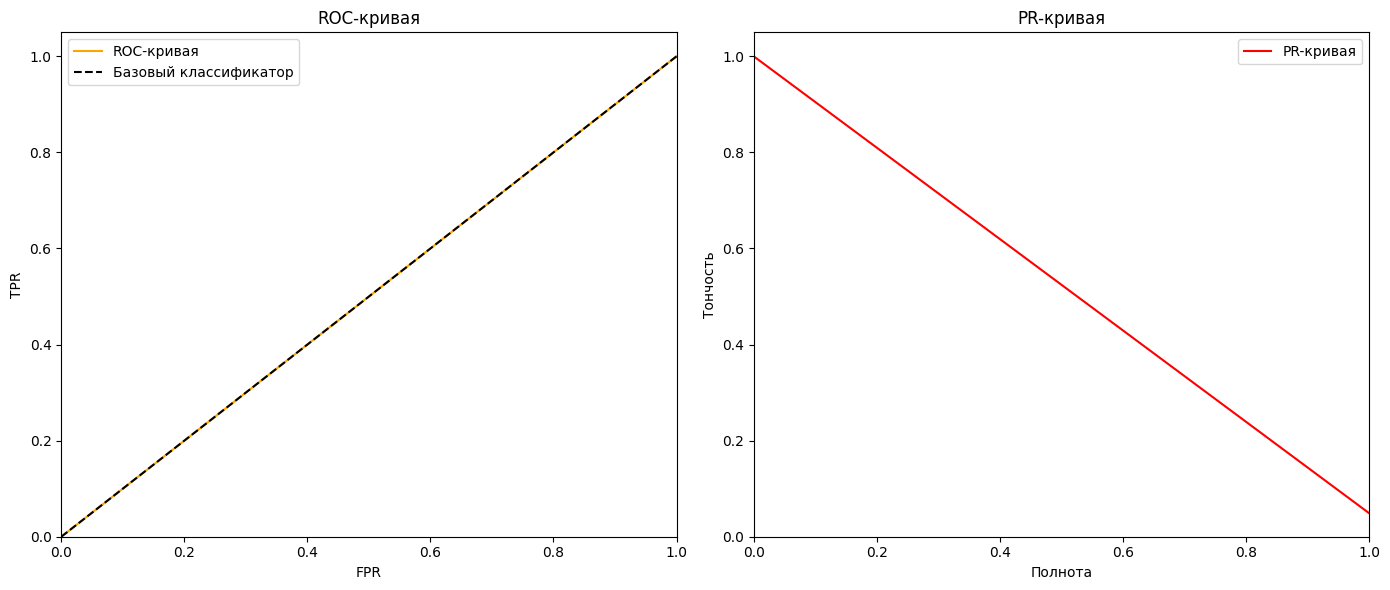

In [ ]:
metrics.append(full_report(y_test, dummy.predict(x_test), dummy.predict_proba(x_test)[:,1], 'dummy'))

In [ ]:
lr = GridSearchCV(
        LogisticRegression(random_state=42, max_iter=1000),
        {'class_weight': ['balanced',
                          {0: 1.0,
                          1: 5.0},
                          {0: 1.0,
                          1: 25.0},
                          {0: 1.0,
                          1: 100.0},]},
        scoring='f1'
    )
lr.fit(x_train, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=1000, random_state=42),
             param_grid={'class_weight': ['balanced', {0: 1.0, 1: 5.0},
                                          {0: 1.0, 1: 25.0},
                                          {0: 1.0, 1: 100.0}]},
             scoring='f1')

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4754
           1       0.44      0.47      0.45       246

    accuracy                           0.94      5000
   macro avg       0.71      0.72      0.71      5000
weighted avg       0.95      0.94      0.95      5000

ROC-AUC: 0.8374710556108506
PR-AUC: 0.4885700573912299
Матрица ошибок
[[4607  147]
 [ 131  115]]


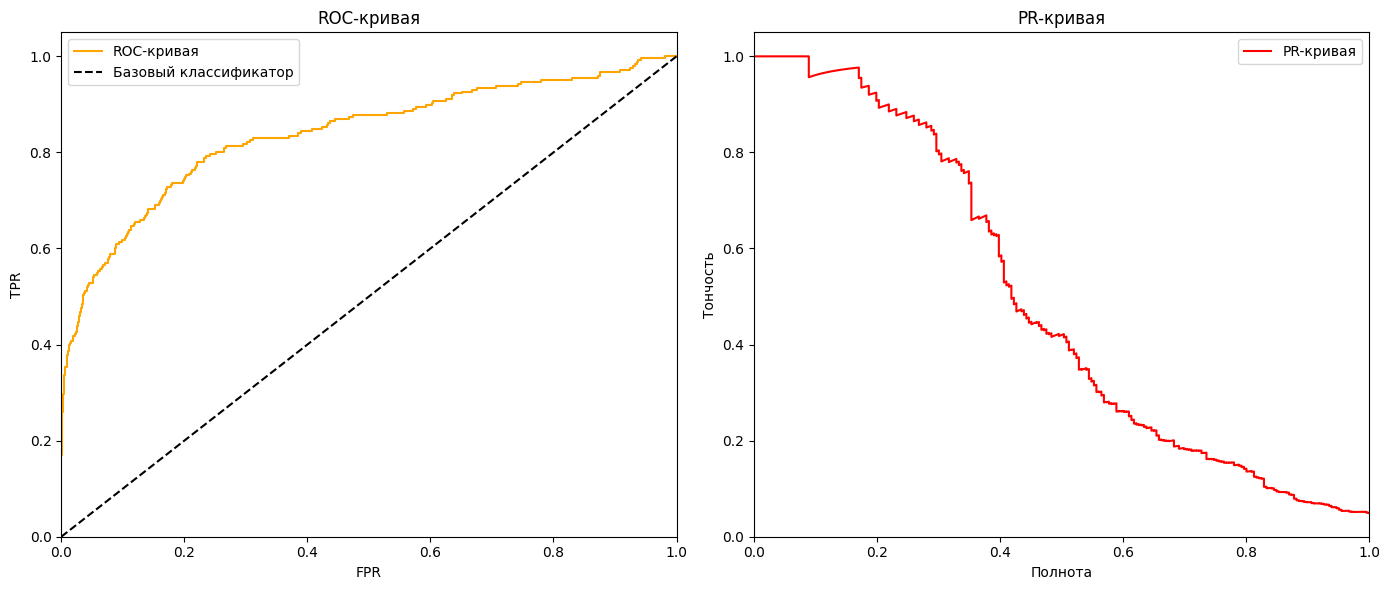

In [ ]:
metrics.append(full_report(y_test, lr.predict(x_test), lr.predict_proba(x_test)[:,1], 'log_reg'))

Уже лучше

# Дерево решений

In [ ]:
tree = GridSearchCV(
        DecisionTreeClassifier(random_state=42),
        {'max_depth': [5, 15, None],
         'min_samples_leaf': [1, 3, 5, 10],
         'class_weight': ['balanced',
                          {0: 1.0,
                          1: 5.0}]},
        scoring='f1'
    )
tree.fit(x_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'class_weight': ['balanced', {0: 1.0, 1: 5.0}],
                         'max_depth': [5, 15, None],
                         'min_samples_leaf': [1, 3, 5, 10]},
             scoring='f1')

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4754
           1       0.53      0.52      0.52       246

    accuracy                           0.95      5000
   macro avg       0.75      0.75      0.75      5000
weighted avg       0.95      0.95      0.95      5000

ROC-AUC: 0.6703097263408477
PR-AUC: 0.2724642099161356
Матрица ошибок
[[4640  114]
 [ 119  127]]


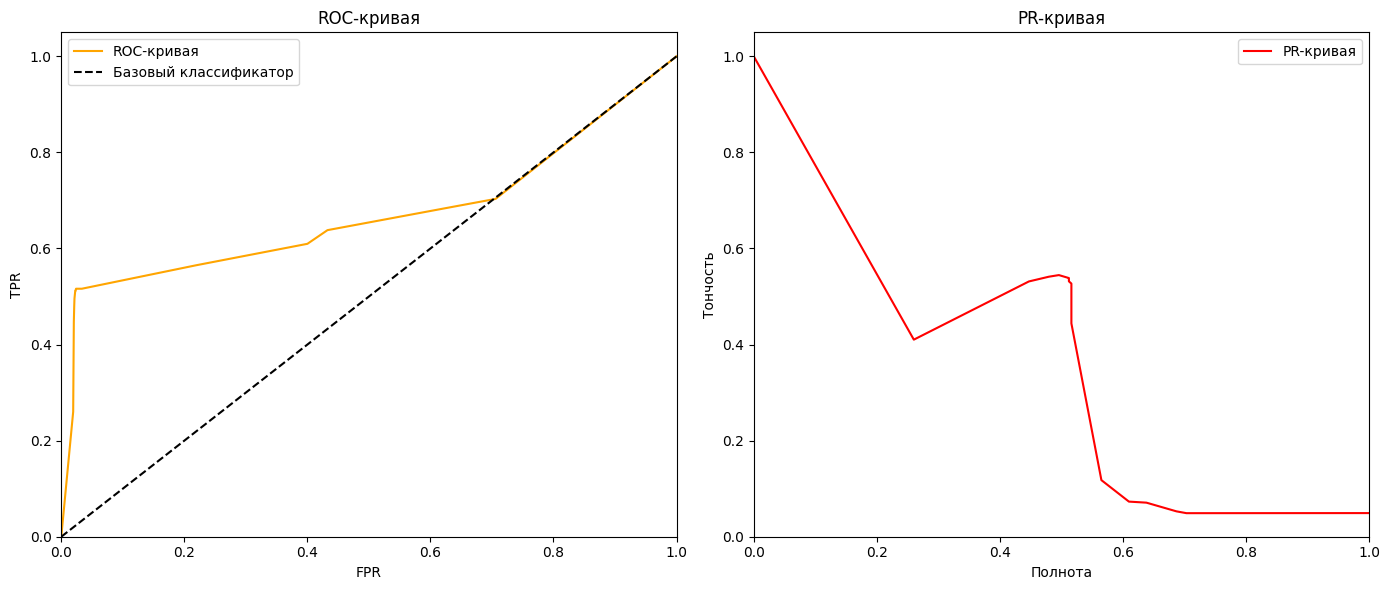

In [ ]:
metrics.append(full_report(y_test, tree.predict(x_test), tree.predict_proba(x_test)[:,1], 'tree'))

# Случайный лес

In [ ]:
forest = GridSearchCV(
        RandomForestClassifier(random_state=42, class_weight='balanced_subsample'),
        {'n_estimators': [50, 100, 300],
         'max_features': ['sqrt', 15, 25]},
        scoring='f1'
    )
forest.fit(x_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                              random_state=42),
             param_grid={'max_features': ['sqrt', 15, 25],
                         'n_estimators': [50, 100, 300]},
             scoring='f1')

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      4754
           1       0.98      0.46      0.63       246

    accuracy                           0.97      5000
   macro avg       0.98      0.73      0.81      5000
weighted avg       0.97      0.97      0.97      5000

ROC-AUC: 0.8990943869261999
PR-AUC: 0.7691681739101286
Матрица ошибок
[[4752    2]
 [ 132  114]]


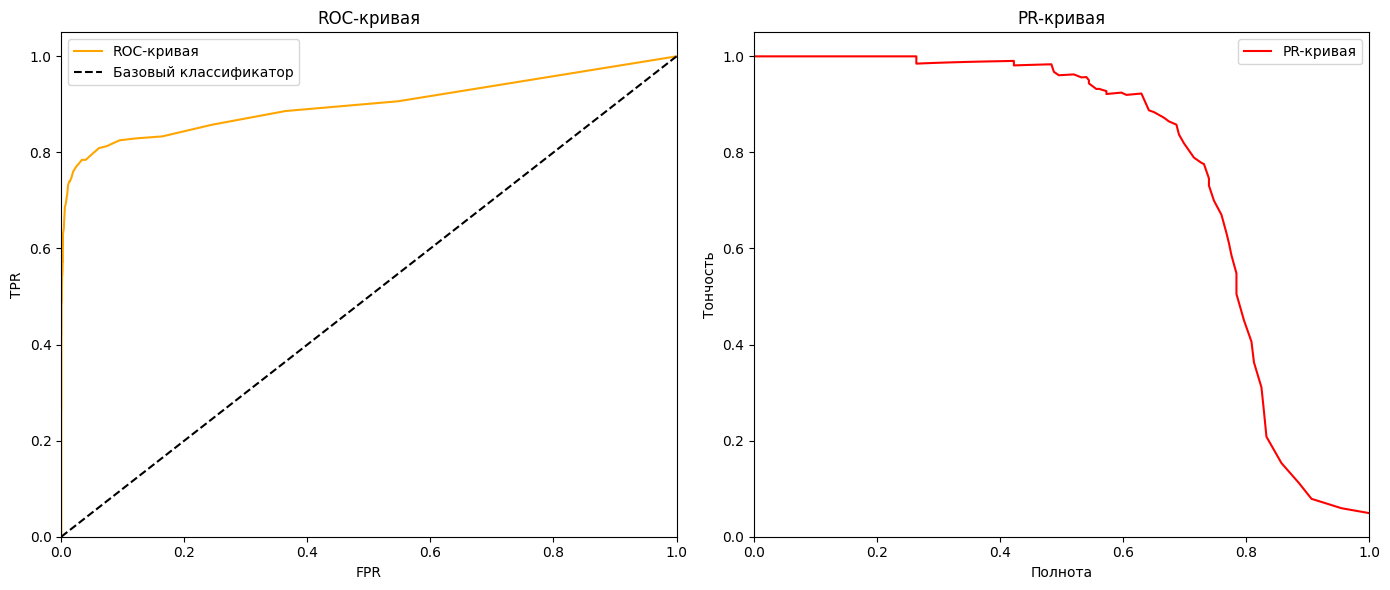

In [ ]:
metrics.append(full_report(y_test, forest.predict(x_test), forest.predict_proba(x_test)[:,1], 'forest'))

# Градиентный бустинг

In [ ]:
boosting = GridSearchCV(
        GradientBoostingClassifier(random_state=42, n_estimators=300),
        {'learning_rate': [1.0, 0.1, 0.001, 0.01],
         'max_depth': [1, 2, 3]},
        scoring='f1'
    )
boosting.fit(x_train, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(n_estimators=300,
                                                  random_state=42),
             param_grid={'learning_rate': [1.0, 0.1, 0.001, 0.01],
                         'max_depth': [1, 2, 3]},
             scoring='f1')

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4754
           1       0.87      0.60      0.71       246

    accuracy                           0.98      5000
   macro avg       0.92      0.80      0.85      5000
weighted avg       0.97      0.98      0.97      5000

ROC-AUC: 0.8978985603907363
PR-AUC: 0.7151652684408367
Матрица ошибок
[[4731   23]
 [  98  148]]


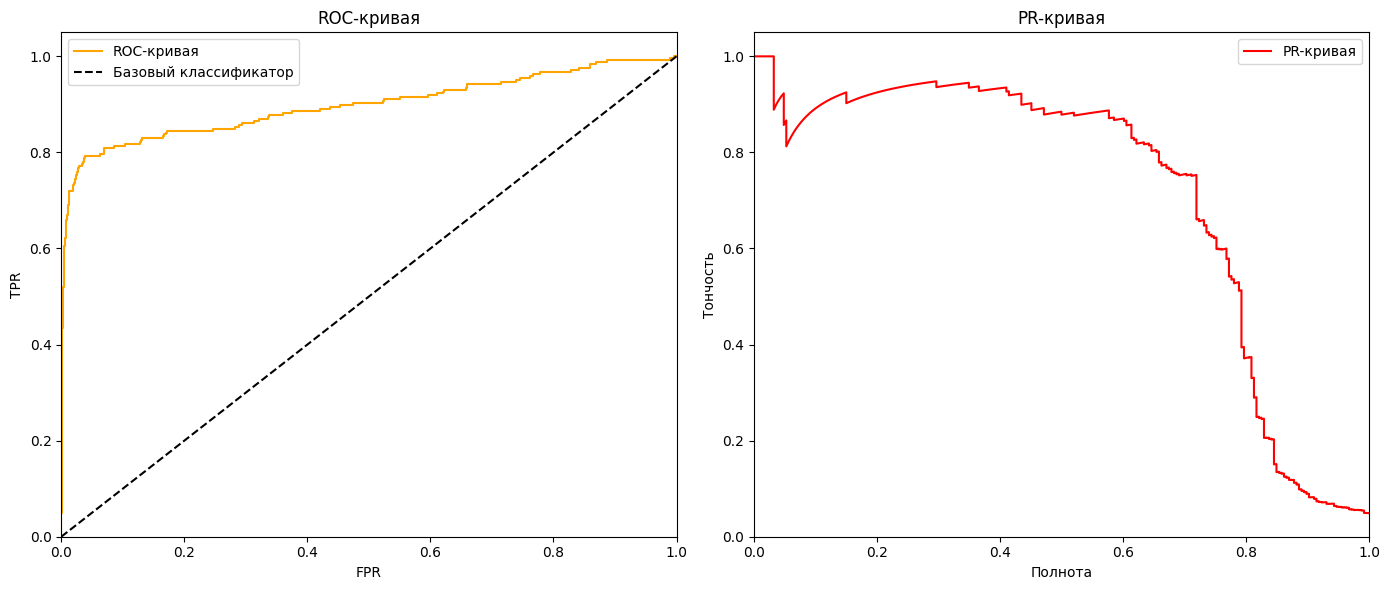

In [ ]:
metrics.append(full_report(y_test, boosting.predict(x_test), boosting.predict_proba(x_test)[:,1], 'gr_boosting'))

Лучшей моделью признаем градиентный бустинг, т.к. разница между ним и случайным лесом в ROC-AUC и PR-AUC не столь значительна, а вот f1 заметно больше (модель лучше справляется с обнаружением меньшего класса)

# Интерпретация

Важность признака на основе частоты перестановки

In [ ]:
best_model = boosting.best_estimator_
boosting.best_params_

{'learning_rate': 0.1, 'max_depth': 3}

In [ ]:
pi = permutation_importance(
    best_model,
    x_test,
    y_test,
    n_repeats=10,
    random_state=42,
)

sorted_idx = pi.importances_mean.argsort()[::-1]

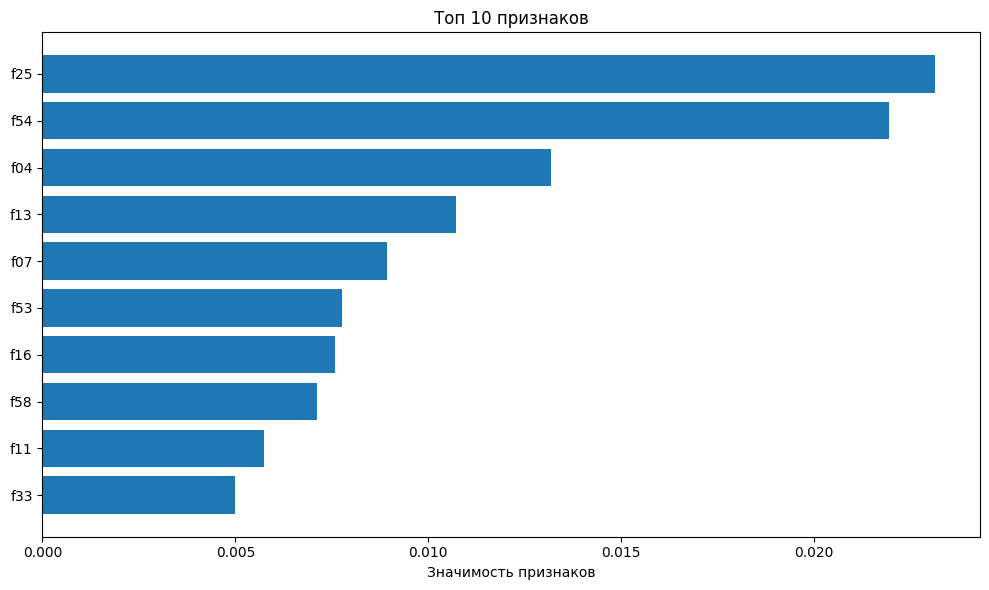

In [ ]:
top_idx = sorted_idx[:10]

plt.figure(figsize=(10, 6))
plt.barh(range(10), pi.importances_mean[top_idx][::-1])
plt.yticks(range(10), data.drop(['id', 'target'], axis=1).columns[top_idx][::-1])
plt.xlabel("Значимость признаков")
plt.title("Топ 10 признаков")
plt.tight_layout()
plt.show()

Важность на основе частоты деления в деревьях

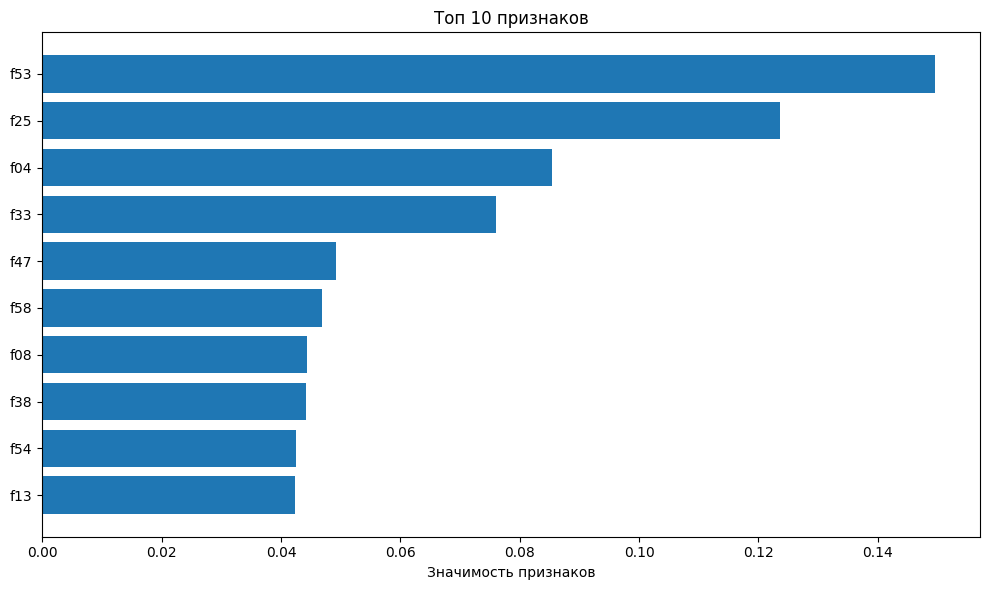

In [ ]:
feature_importances = best_model.feature_importances_
sorted_idx = feature_importances.argsort()[::-1]
top_idx = sorted_idx[:10]

plt.figure(figsize=(10, 6))
plt.barh(range(10), feature_importances[top_idx][::-1])
plt.yticks(range(10), data.drop(['id', 'target'], axis=1).columns[top_idx][::-1])
plt.xlabel("Значимость признаков")
plt.title("Топ 10 признаков")
plt.tight_layout()
plt.savefig(f'artifacts/figures/importance.png')
plt.show()

Некоторые признаки (например, f25, f04) совпали. Они точно значимы

# Артефакты

In [ ]:
with open("artifacts/metrics_test.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, ensure_ascii=False, indent=2)

In [ ]:
search_summaries = []

for m in dummy, lr, tree, forest, boosting:
  search_summaries.append(
      {
          'model_name' : type(m.best_estimator_).__name__,
          'cv_score (f1)': float(m.best_score_),
          'best_params': m.best_params_
      }
  )


In [ ]:
with open("artifacts/search_summaries.json", "w", encoding="utf-8") as f:
    json.dump(search_summaries, f, ensure_ascii=False, indent=2)

In [ ]:
dump(boosting.best_estimator_,'artifacts/best_model.joblib')

['artifacts/best_model.joblib']

In [ ]:
with open("artifacts/best_model_meta.json", "w", encoding="utf-8") as f:
    json.dump({
                'best_model' : type(boosting.best_estimator_).__name__,
                'cv_score' : search_summaries[-1],
                'test_score': metrics[-1]
              },
              f,
              ensure_ascii=False,
              indent=2)